# **Multi Label Image Clasification For Movie Poster Genres - CNN**
## Group - 12



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### **Extracting the dataset**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DL-Project/Movies-Poster_Dataset/train.csv')
df.shape

(7254, 27)

>The train.csv file contains all the movie poster image names and all the classes it belongs to. This Movie Poster dataset contains around 7800 images ranging from over 25 different genres of movies.

In [ ]:
img_folder = '/content/drive/MyDrive/DL-Project/Movies-Poster_Dataset/Images/'

> Image folder contains all the movie poster images in .jpg format.

In [ ]:
class ImageDataset(Dataset):
  
  def __init__(self,csv,img_folder,transform):
    self.csv=csv
    self.transform=transform
    self.img_folder=img_folder
    
    self.image_names=self.csv[:]['Id']
    self.labels=np.array(self.csv.drop(['Id', 'Genre'], axis=1))
  
  def __len__(self):
    return len(self.image_names)

  def __getitem__(self,index):
    
    image=cv2.imread(self.img_folder+self.image_names.iloc[index]+'.jpg')
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    image=self.transform(image)
    targets=self.labels[index]

    return (image,targets)

Here we create an **ImageDataset** class which is used for transformation of the images.The images are resized, converted to PIL images and then transformed into tensor arrays. The transformed dataset along with csv and the image folder is passed as the parameters for instantiating the class. Within the constructor the labels and the corresponding image id's are seperated. 

The __getitem__() function is used to read the images from the directory and convert them into RGB color space. A tuple containing the image tensor and the corresponding targets are returned.

In [ ]:
from sklearn.model_selection import train_test_split
train_set,test_set=train_test_split(df,test_size=0.15)

> The dataset is then split to train and test data.

In [ ]:
len(train_set)

6165

> The training set contains 6165 samples.

In [ ]:
len(test_set)

1089

> The testing set contains 1089 samples.

In [ ]:
train_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((350, 350)),
                transforms.ToTensor()])

test_transform =transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((350, 350)),
                transforms.ToTensor()])

train_dataset=ImageDataset(train_set,img_folder,train_transform)
test_dataset=ImageDataset(test_set,img_folder,test_transform)

Our  image  dataset  consists  of  3  channel  RGB  color  space images of varying sizes, which had to be resized to a dimension of 350 x 350 pixels for better and efficient training. The resized images were then transformed to tensors. Thus the transformed dataset was passed as parameters for instantiating the **ImageDataset** class along with the image folder and the seperted training/testing data. 

**train_dataset** and **test_dataset** consists of transformed image samples and their targets.

In [ ]:
img,labels = train_dataset.__getitem__(0)  #FOR PREVIEW
print(img.shape, labels)

torch.Size([3, 350, 350]) [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


> Preview of a transformed sample along with the corresponding targets (25 genres).

In [ ]:
num_classes = 25
batch_size = 33

In [ ]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=True
)

Batch sizes and iterations - MiniBatch

In order to make the datasets iteratable, Dataloaders were used. **train and test dataloaders** were created containing images divided into batches of size 33. 

In [ ]:
df

Id                                Genre  ...  War  Western
0     tt0086425                  ['Comedy', 'Drama']  ...    0        0
1     tt0085549        ['Drama', 'Romance', 'Music']  ...    0        0
2     tt0086465                           ['Comedy']  ...    0        0
3     tt0086567               ['Sci-Fi', 'Thriller']  ...    0        0
4     tt0086034  ['Action', 'Adventure', 'Thriller']  ...    0        0
...         ...                                  ...  ...  ...      ...
7249  tt2409818      ['Action', 'Crime', 'Thriller']  ...    0        0
7250  tt2062622    ['Animation', 'Comedy', 'Family']  ...    0        0
7251  tt2442502                           ['Comedy']  ...    0        0
7252  tt3455850                      ['Documentary']  ...    0        0
7253  tt4179482                        ['Animation']  ...    0        0

[7254 rows x 27 columns]

### **Previewing a sample**

In [ ]:
df_copy = df
image_dict = df_copy.drop(['Id', 'Genre'], axis=1)

In [ ]:
d = {}

i = 0
for gen in image_dict.columns:

  d[i] = gen
  i+=1

In [ ]:
d

{0: 'Action',
 1: 'Adventure',
 2: 'Animation',
 3: 'Biography',
 4: 'Comedy',
 5: 'Crime',
 6: 'Documentary',
 7: 'Drama',
 8: 'Family',
 9: 'Fantasy',
 10: 'History',
 11: 'Horror',
 12: 'Music',
 13: 'Musical',
 14: 'Mystery',
 15: 'N/A',
 16: 'News',
 17: 'Reality-TV',
 18: 'Romance',
 19: 'Sci-Fi',
 20: 'Short',
 21: 'Sport',
 22: 'Thriller',
 23: 'War',
 24: 'Western'}

> Dictionary containing column numbers and the corresponding genres as key-value pairs.

In [ ]:
dataiter = iter(train_dataloader)
images,targets = dataiter.next()

In [ ]:
print(images.shape)

torch.Size([33, 3, 350, 350])


>Torch size indicating 3 channel color space RGB images of batch size 33 with dimensions 350x350.

In [ ]:
print(images[1].shape)

torch.Size([3, 350, 350])


In [ ]:
print(targets[0])

tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])


## **Visualise data**
To display image which is a tensor, permute is done along with imshow() to rearrange the dimensions without changing it's size.

Documentary


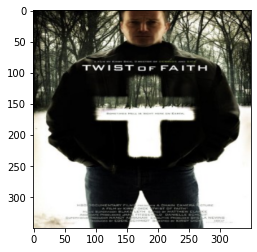

In [ ]:
def show_example(img, label,d):

    for index in range(len(labels)):

      if(labels[index]==1):
        print(d[index])
        
    plt.imshow(img.permute(1, 2, 0))
  
show_example(img,labels,d)

### **Image Grid of batch size 33**

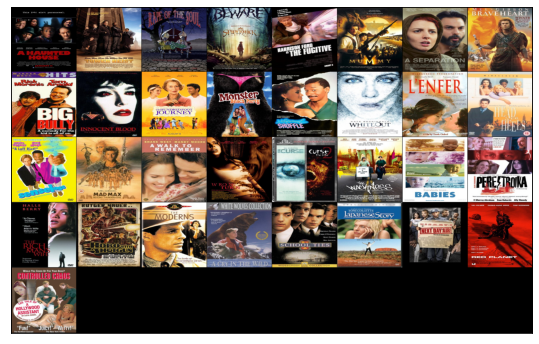

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break
        
show_batch(train_dataloader)

In [ ]:
from torchvision import models
import torch.nn as nn
import copy

In [ ]:
resnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

> Creating a resnet model by instantiating the pre-trained **resnet50** model class from torchvision. We keep the intermediate layer weights frozen and only make the final classification head learnable.

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

>For the ResNet50 model, we will be using the pre-trained weights. But we will not be updating the weights of the intermediate layers. And that’s why we are passing the argument as **requires_grad=False**

In [ ]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

>Here we apply a linear transformation to the input sample.

In [ ]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([25, 2048])
torch.Size([25])


In [ ]:
resnet = resnet.to(device)
opt = optim.Adam(resnet.parameters(), lr=0.0001)
loss_fn = nn.BCELoss()

For Backpropagation we create an instance of loss function which is **Binary Cross Entropy Loss** (BCELoss). We also instantiate **Adam optimiser** to optimise all the parameters with a learning rate of 0.0001.

In [ ]:
def evaluation(dataloader, model):
    
    total, correct = 0, 0
    count = 0
    
    for data in dataloader:
        
        count+=1

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)

        kvals, kidx = outputs.topk(3, dim=1)
        outputs.zero_()
        outputs[torch.arange(outputs.size(0))[:, None], kidx] = 1
        
        #print("PREDICTED OUTPUTS: ",outputs)
        #print("LABELS :", labels)


        for i,j in zip(outputs,labels):
          
          for x in range(len(i)):
            
            if(j[x]==1):
              total+=1

              if(i[x]==1 and j[x]==1):
                correct += 1

          #print ("PRED:",(i == 1).nonzero(as_tuple=True)[0])
          #print ("LABEL:",(j == 1).nonzero(as_tuple=True)[0])
          
        #print("DEBUG:",100*correct/total)
        
        #total += labels.size(0)
        #correct += (outputs == labels).sum().item()
    
    print("CORRECT:",correct)
    print("TOTAL:",total)
    return (100*correct/total)

The **evaluation()** function takes in the test/train dataloader along with the model as parameters. The objective of this function is to calculate the accuracy of predicted outputs and evaluate the model. At the final layer we make use of a sigmoid activation function to convert the values within  the  final  node  into  a  probability  score  between  0  and 1. 

In order to solve the problem by classifying the probabilty scores obtained in the previous step into binary values (i.e 0 & 1), we take the top 3 highest values of the output tensor and convert it into 1's and the rest into 0's. We make use of **topk()** function from pytorch inorder to accomplish this.

The accuracy score for the models were calculated by counting the 1's belonging to both the actual and predicted tensors, which were in the same index position. This method was repeated for each image in the batch and the counter was incremented each time the above condition was satisfied. A total count variable was initialized to count the number of 1's in the label tensor. 

The accuracy was obtained by dividing the final counter value with the total count value, multiplied by 100.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


CORRECT: 1319
TOTAL: 2513
CORRECT: 7277
TOTAL: 14361
Epoch: 0/30, Test acc: 52.49, Train acc: 50.67
CORRECT: 1373
TOTAL: 2513
CORRECT: 7666
TOTAL: 14361
Epoch: 1/30, Test acc: 54.64, Train acc: 53.38
CORRECT: 1412
TOTAL: 2513
CORRECT: 8004
TOTAL: 14361
Epoch: 2/30, Test acc: 56.19, Train acc: 55.73
CORRECT: 1435
TOTAL: 2513
CORRECT: 8083
TOTAL: 14361
Epoch: 3/30, Test acc: 57.10, Train acc: 56.28
CORRECT: 1436
TOTAL: 2513
CORRECT: 8147
TOTAL: 14361
Epoch: 4/30, Test acc: 57.14, Train acc: 56.73
CORRECT: 1455
TOTAL: 2513
CORRECT: 8243
TOTAL: 14361
Epoch: 5/30, Test acc: 57.90, Train acc: 57.40
CORRECT: 1467
TOTAL: 2513
CORRECT: 8370
TOTAL: 14361
Epoch: 6/30, Test acc: 58.38, Train acc: 58.28
CORRECT: 1465
TOTAL: 2513
CORRECT: 8397
TOTAL: 14361
Epoch: 7/30, Test acc: 58.30, Train acc: 58.47
CORRECT: 1474
TOTAL: 2513
CORRECT: 8415
TOTAL: 14361
Epoch: 8/30, Test acc: 58.65, Train acc: 58.60
CORRECT: 1484
TOTAL: 2513
CORRECT: 8452
TOTAL: 14361
Epoch: 9/30, Test acc: 59.05, Train acc: 58.85


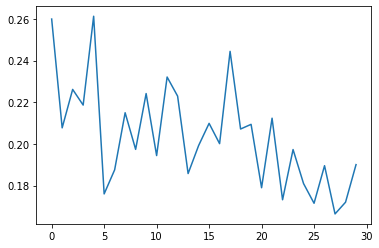

In [ ]:
loss_arr = []
loss_epoch_arr = []
max_epochs = 30

min_loss = 1000

n_iters = np.ceil(len(train_dataset)/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(train_dataloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        outputs = torch.sigmoid(outputs)
        loss = loss_fn(outputs, labels.float())
        loss.backward()
        
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            #print('Min loss %0.2f' % min_loss)
            loss_arr.append(min_loss)
        
        #if i % 100 == 0:
            #print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(test_dataloader, resnet), evaluation(train_dataloader, resnet)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

## **Training/Testing the models**
* For each epoch, we iterate through the data loader.
* Get the input data and labels, then move them to GPU (if available).
* Here we reset any previous gradient present in the optimizer, before computing the gradient for the next batch.
* Then we pass the inputs to the pre-trained resnet model inorder to predict the output.
* Now, we compute the loss based on the predicted output and actual output.
* Then backpropagate the gradients to minimize the loss.
* At end of each epoch, we are bookmarking the loss values for plotting and printing the progress messages.

For storing the loss in each epoch and iteration, we use
  * loss_arr.append(loss.item())
  * loss_epoch_arr.append(loss.item())

### **Testing the model**

In [ ]:
genres = df.columns.values[2:]
genres

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'N/A', 'News', 'Reality-TV',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western'], dtype=object)

>Array containing the genre names.

In [ ]:
checker_dataloader = DataLoader(
    test_dataset, 
    batch_size=1,
    shuffle=True
)

>Dataloader created for testing the model, here batch_size is given as 1 because we want to preview each image instead of all 33 together. 

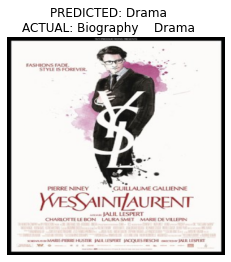

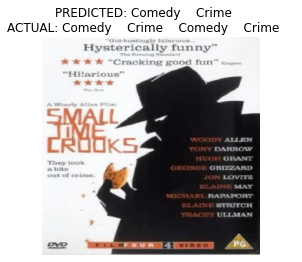

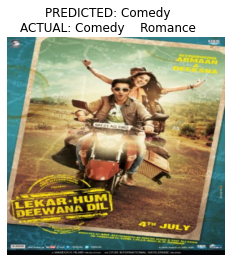

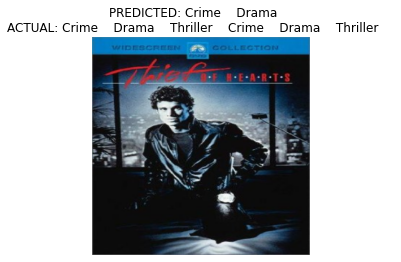

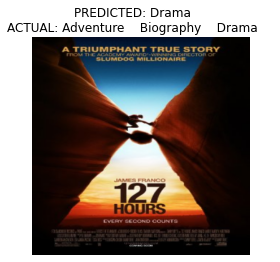

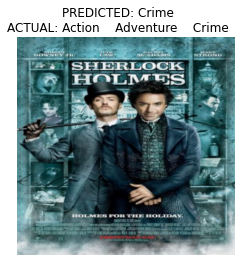

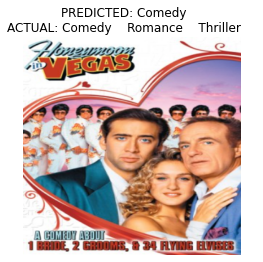

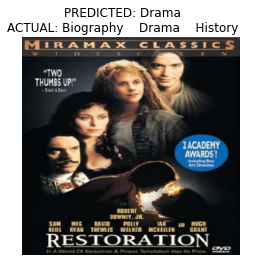

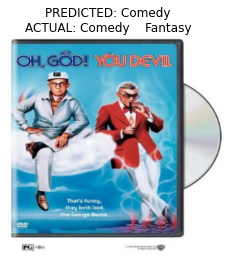

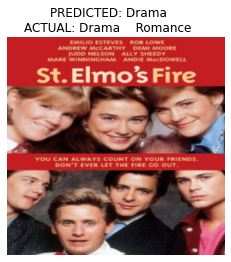

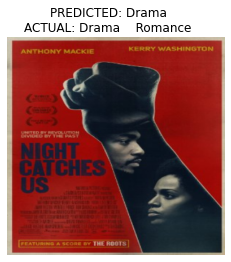

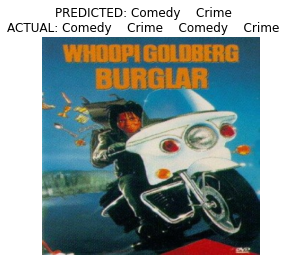

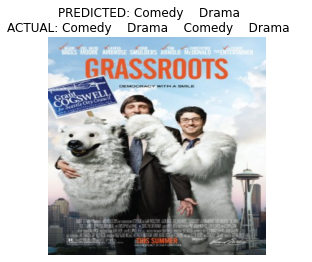

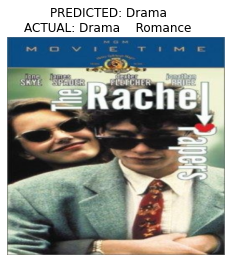

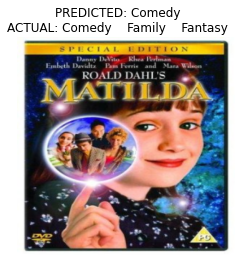

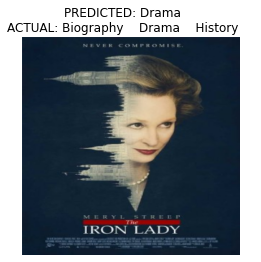

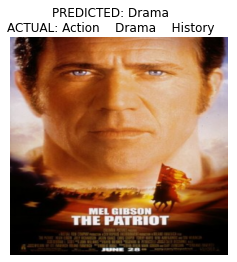

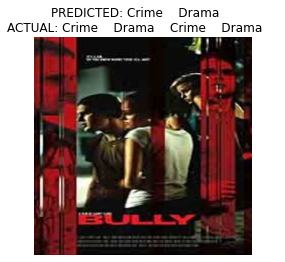

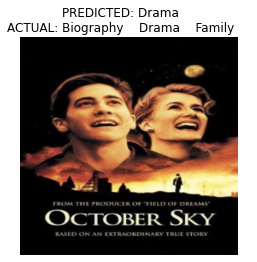

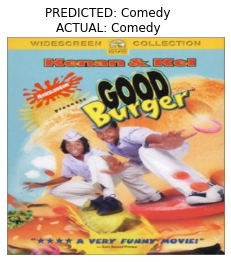

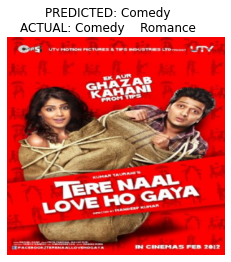

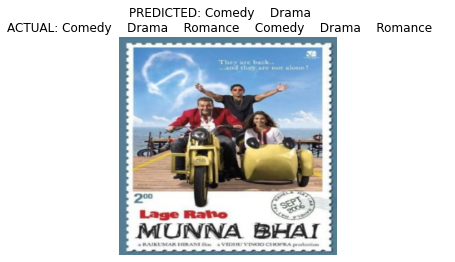

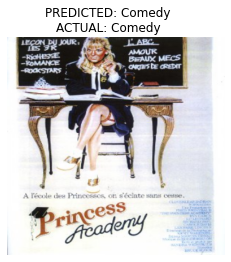

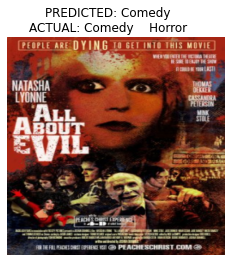

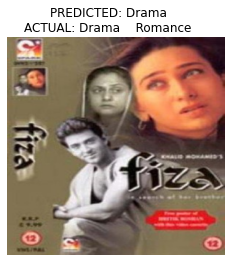

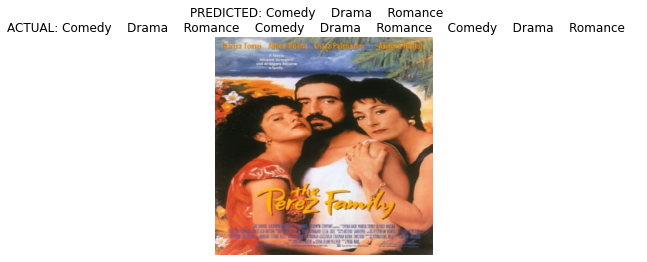

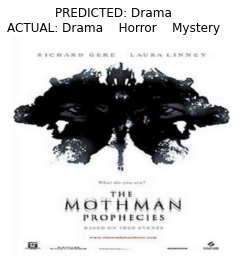

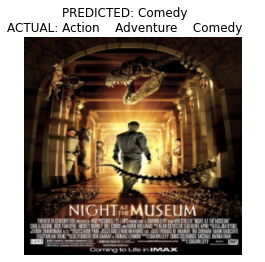

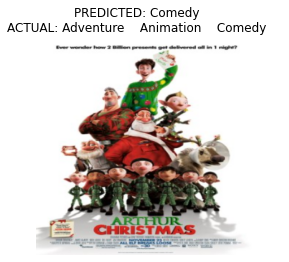

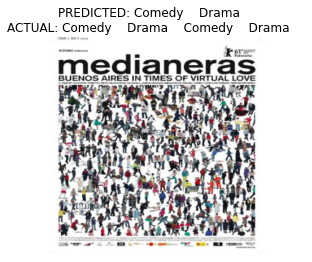

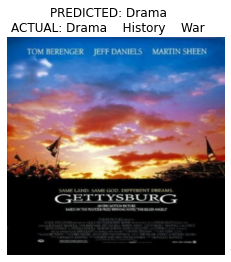

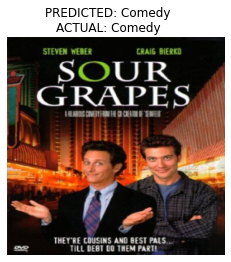

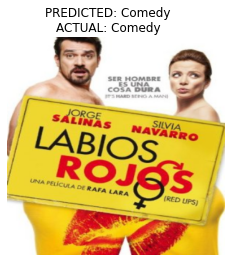

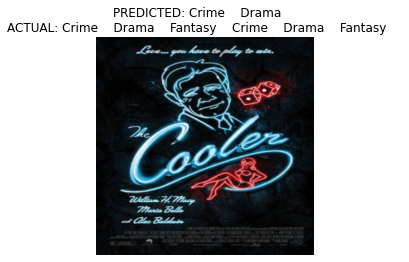

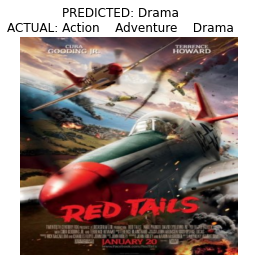

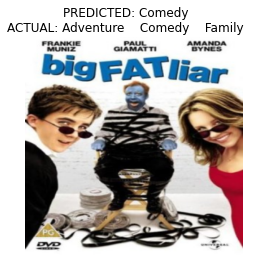

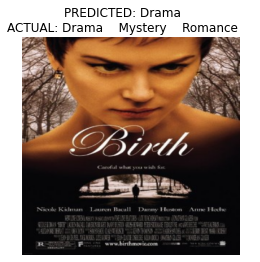

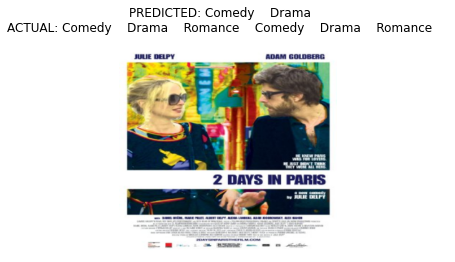

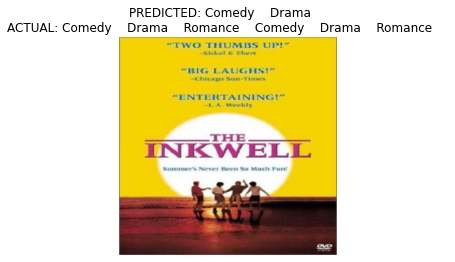

In [ ]:
counter = 0

for counter, data in enumerate(checker_dataloader):

    if(counter == 50):
      break

      counter+=1

    image, target = data
    image, target = image.to(device), target.to(device)

    outputs = resnet(image)
    outputs = torch.sigmoid(outputs)

    kvals, kidx = outputs.topk(3, dim=1)
    outputs.zero_()
    outputs[torch.arange(outputs.size(0))[:, None], kidx] = 1

    for i,j in zip(outputs,target):

      string_predicted = ''
      string_actual = ''
      flg = 0
      
      for x in range(len(i)):
        
        if(i[x]==1):

          if(j[x]==1):

            for k in range(len(j)):
              if(j[k] == 1):
                string_actual += f"{genres[k]}    "
            
            string_predicted += f"{genres[x]}    "
            flg = 1

      if(flg == 1):

        image = image.squeeze(0)
        image = image.detach().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow(image)

        plt.axis('off')
        plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
        #plt.savefig(f"../outputs/inference_{counter}.jpg")
        plt.show()